In [1]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [2]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

| using device: cpu


In [3]:
# hyperparams
bsz = 10

## Data

In [31]:
# data.py
import os
import gzip
import numpy as np
import torch
from torch.utils.data import Dataset

class MNISTFromRaw(Dataset):
    def __init__(self, images_u8: np.ndarray, labels_u8: np.ndarray, normalize=True):
        """
        images_u8: uint8 array of shape (N, 28, 28)
        labels_u8: uint8 array of shape (N,)
        """
        assert images_u8.ndim == 3 and images_u8.shape[1:] == (28, 28)
        assert labels_u8.ndim == 1 and images_u8.shape[0] == labels_u8.shape[0]

        self.images = images_u8
        self.labels = labels_u8
        self.normalize = normalize

        # MNIST normalization constants (same as torchvision example)
        self.mean = 0.1307
        self.std  = 0.3081

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]  # (28, 28) uint8
        y = int(self.labels[idx])

        # convert to float tensor in [0,1], shape (1,28,28)
        x = torch.from_numpy(img).float().unsqueeze(0) / 255.0

        if self.normalize:
            x = (x - self.mean) / self.std

        return x, y


def _read_idx_gz(path: str) -> np.ndarray:
    with gzip.open(path, "rb") as f:
        data = f.read()

    # IDX format: big-endian
    # first 4 bytes: magic number
    magic = int.from_bytes(data[0:4], byteorder="big")
    if magic == 2051:  # images
        n = int.from_bytes(data[4:8], "big")
        rows = int.from_bytes(data[8:12], "big")
        cols = int.from_bytes(data[12:16], "big")
        arr = np.frombuffer(data, dtype=np.uint8, offset=16)
        arr = arr.reshape(n, rows, cols)
        return arr
    elif magic == 2049:  # labels
        n = int.from_bytes(data[4:8], "big")
        arr = np.frombuffer(data, dtype=np.uint8, offset=8)
        arr = arr.reshape(n,)
        return arr
    else:
        raise RuntimeError(f"Unknown IDX magic {magic} in file: {path}")


def fetch_dataset(root="./data"):
    """
    Expects:
      {root}/MNIST/raw/train-images-idx3-ubyte.gz
      {root}/MNIST/raw/train-labels-idx1-ubyte.gz
      {root}/MNIST/raw/t10k-images-idx3-ubyte.gz
      {root}/MNIST/raw/t10k-labels-idx1-ubyte.gz
    """
    raw_dir = os.path.join(root, "MNIST", "raw")
    required = {
        "train_images": os.path.join(raw_dir, "train-images-idx3-ubyte.gz"),
        "train_labels": os.path.join(raw_dir, "train-labels-idx1-ubyte.gz"),
        "test_images":  os.path.join(raw_dir, "t10k-images-idx3-ubyte.gz"),
        "test_labels":  os.path.join(raw_dir, "t10k-labels-idx1-ubyte.gz"),
    }
    missing = [p for p in required.values() if not os.path.exists(p)]
    if missing:
        raise RuntimeError(
            "MNIST raw .gz files missing. Expected them in:\n"
            f"  {raw_dir}\n\nMissing:\n  - " + "\n  - ".join(missing)
        )

    Xtr = _read_idx_gz(required["train_images"])
    ytr = _read_idx_gz(required["train_labels"])
    Xte = _read_idx_gz(required["test_images"])
    yte = _read_idx_gz(required["test_labels"])

    train_data = MNISTFromRaw(Xtr, ytr, normalize=True)
    test_data  = MNISTFromRaw(Xte, yte, normalize=True)
    return train_data, test_data

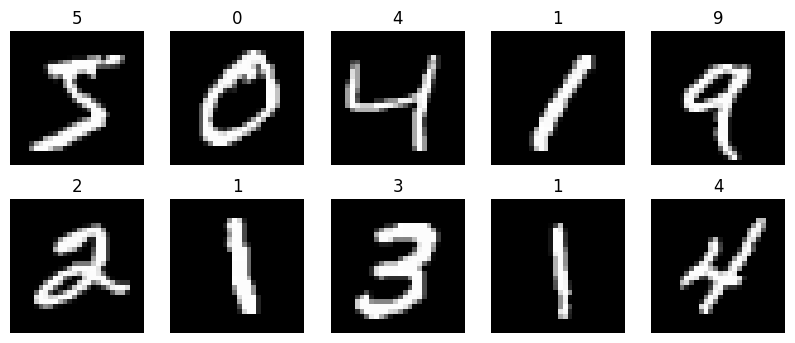

In [33]:
train_data, test_data = fetch_dataset()

test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [34]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)

iid:  tensor([66., 64., 62., 52., 50., 54., 59., 64., 49., 80.])


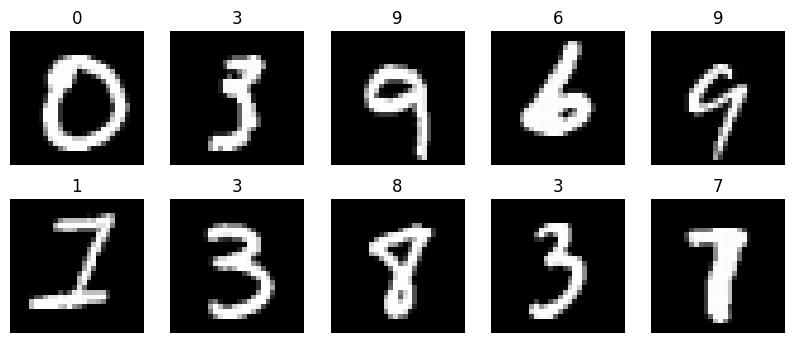

In [35]:
# iid
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)

non-iid:  tensor([  0.,   0.,   0., 300.,   0.,   0.,   0.,   0.,   0., 300.])


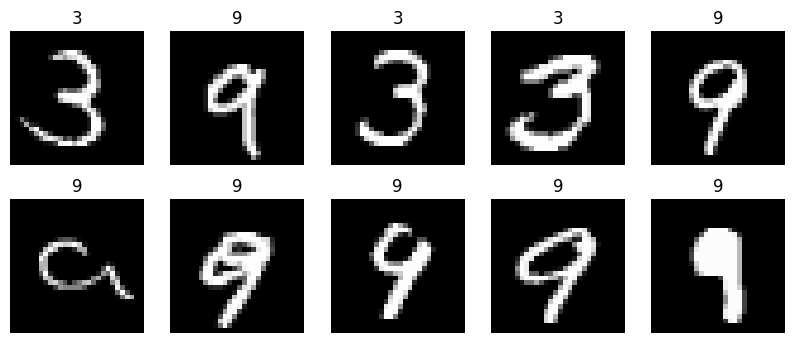

In [36]:
# non-iid
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)

## Models

In [38]:
# define fully connected NN

import torch
import torch.nn as nn
import torch.nn.functional as F

def num_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.out = nn.Linear(200, 10)

    def forward(self, x):
        x = x.flatten(1)        # [B, 784]
        x = F.relu(self.fc1(x)) # [B, 200]
        x = F.relu(self.fc2(x)) # [B, 200]
        x = self.out(x)         # [B, 10]
        return x

m = MLP()
print(m)
print("Trainable params:", num_params(m))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
Trainable params: 199210


In [39]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) 
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(1024, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2, 2) # [B x 32 x 12 x 12]
        x = F.max_pool2d(self.conv2(x), 2, 2) # [B x 64 x 4 x 4]
        x = x.flatten(1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())
print(num_params(CNN()))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
582026


## Training

In [51]:
criterion = nn.CrossEntropyLoss()

def validate(model):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [52]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [46]:
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)
        
        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)


 ## MLP experiments

In [47]:
mlp = MLP()
print(mlp)
print("total params: ", num_params(mlp))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
total params:  199210


In [53]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MLP - iid - m=10 experiment
mlp_iid_m10 = copy.deepcopy(mlp)
acc_mlp_iid_m10 = fed_avg_experiment(mlp_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m10')
print(acc_mlp_iid_m10)
np.save('./acc_mlp_iid_m10.npy', acc_mlp_iid_m10)

starting round 0
clients:  [54 84 33 53  2 49 48 82 41 66]
round 0, starting client 1/10, id: 54
round 0, starting client 2/10, id: 84
round 0, starting client 3/10, id: 33
round 0, starting client 4/10, id: 53
round 0, starting client 5/10, id: 2
round 0, starting client 6/10, id: 49
round 0, starting client 7/10, id: 48
round 0, starting client 8/10, id: 82
round 0, starting client 9/10, id: 41
round 0, starting client 10/10, id: 66
round 0, validation acc: 0.8184
starting round 1
clients:  [89 56 37 46  2 90 13 15 58 67]
round 1, starting client 1/10, id: 89
round 1, starting client 2/10, id: 56
round 1, starting client 3/10, id: 37
round 1, starting client 4/10, id: 46
round 1, starting client 5/10, id: 2
round 1, starting client 6/10, id: 90
round 1, starting client 7/10, id: 13
round 1, starting client 8/10, id: 15
round 1, starting client 9/10, id: 58
round 1, starting client 10/10, id: 67
round 1, validation acc: 0.8755
starting round 2
clients:  [93 49 68 23  9 67 72 82 92 85]

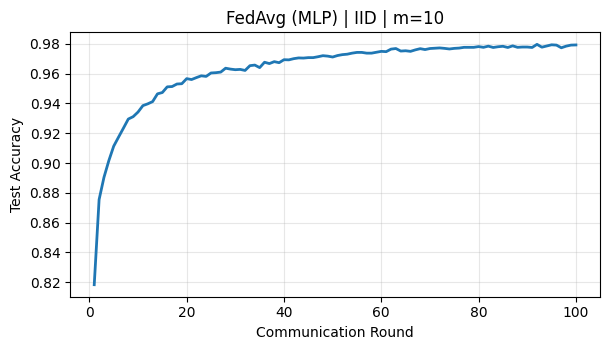

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def plot_curve(acc, ylabel="Test Accuracy", title="FedAvg (MLP)"):
    acc = np.asarray(acc)

    fig = plt.figure(figsize=(6.2, 3.6))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(1, len(acc)+1), acc, linewidth=2)

    ax.set_xlabel("Communication Round")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    fig.tight_layout()
    return fig

# Example usage
fig = plot_curve(acc_mlp_iid_m10, title="FedAvg (MLP) | IID | m=10")
fig.savefig("acc_mlp_iid_m10.pdf")   # best for papers
fig.savefig("acc_mlp_iid_m10.svg")   # vector
fig.savefig("acc_mlp_iid_m10.png", dpi=300)
plt.show()

In [58]:
def plot_mean_std(curves, title="FedAvg"):
    curves = [np.asarray(c) for c in curves]
    T = min(len(c) for c in curves)
    M = np.stack([c[:T] for c in curves], axis=0)
    mean = M.mean(axis=0)
    std  = M.std(axis=0)

    x = np.arange(1, T+1)
    fig = plt.figure(figsize=(6.2, 3.6))
    ax = fig.add_subplot(111)
    ax.plot(x, mean, linewidth=2)
    ax.fill_between(x, mean-std, mean+std, alpha=0.2)

    ax.set_xlabel("Communication Round")
    ax.set_ylabel("Test Accuracy")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    return fig

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ---- Helpers: flatten params / set params ----
def flatten_params(model: torch.nn.Module) -> torch.Tensor:
    return torch.cat([p.detach().flatten() for p in model.parameters()])

def set_params_from_flat(model: torch.nn.Module, flat: torch.Tensor):
    idx = 0
    with torch.no_grad():
        for p in model.parameters():
            n = p.numel()
            p.copy_(flat[idx:idx+n].view_as(p))
            idx += n

@torch.no_grad()
def eval_loss(model, data_loader, device, max_batches=10):
    model.eval()
    loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
    total_loss, total_n = 0.0, 0
    for b, (x, y) in enumerate(data_loader):
        if b >= max_batches:
            break
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_n += bs
    return total_loss / max(1, total_n)

def random_direction_like(w: torch.Tensor, seed=0):
    # reproducible without generator= (works across more torch versions)
    prev_state = torch.random.get_rng_state()
    torch.manual_seed(seed)
    d = torch.randn_like(w)
    torch.random.set_rng_state(prev_state)

    d = d / (d.norm() + 1e-12)   # unit direction
    return d

def loss_surface_2d(model, loader, device, span=1.0, steps=41, seed1=0, seed2=1, max_batches=10):
    model = model.to(device)
    w0 = flatten_params(model).to(device)

    d1 = random_direction_like(w0, seed=seed1)
    d2 = random_direction_like(w0, seed=seed2)

    # Grid in (alpha, beta)
    alphas = torch.linspace(-span, span, steps, device=device)
    betas  = torch.linspace(-span, span, steps, device=device)

    Z = np.zeros((steps, steps), dtype=np.float64)

    for i, a in enumerate(alphas):
        for j, b in enumerate(betas):
            w = w0 + a * d1 + b * d2
            set_params_from_flat(model, w)
            Z[i, j] = eval_loss(model, loader, device, max_batches=max_batches)

    # restore original weights
    set_params_from_flat(model, w0)
    return alphas.detach().cpu().numpy(), betas.detach().cpu().numpy(), Z

def plot_surface_and_contour(alphas, betas, Z, title="Loss Surface"):
    A, B = np.meshgrid(betas, alphas)  # note order for plotting
    # 3D surface
    fig1 = plt.figure(figsize=(7.0, 4.8))
    ax3d = fig1.add_subplot(111, projection="3d")
    ax3d.plot_surface(A, B, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    ax3d.set_xlabel(r"$\beta$")
    ax3d.set_ylabel(r"$\alpha$")
    ax3d.set_zlabel("Loss")
    ax3d.set_title(title)
    fig1.tight_layout()

    # 2D contour
    fig2 = plt.figure(figsize=(6.2, 4.2))
    ax2 = fig2.add_subplot(111)
    cs = ax2.contour(A, B, Z, levels=25)
    ax2.clabel(cs, inline=True, fontsize=8)
    ax2.set_xlabel(r"$\beta$")
    ax2.set_ylabel(r"$\alpha$")
    ax2.set_title(title + " (Contour)")
    ax2.grid(True, alpha=0.3)
    fig2.tight_layout()

    return fig1, fig2

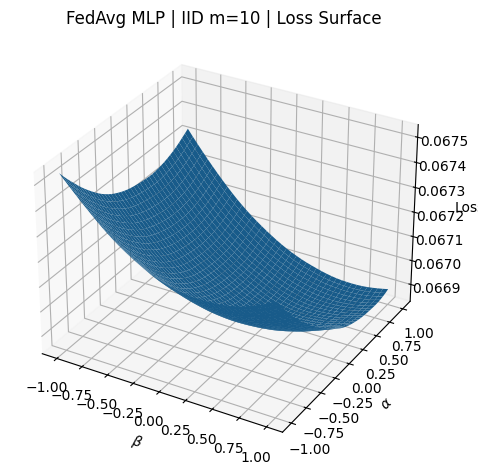

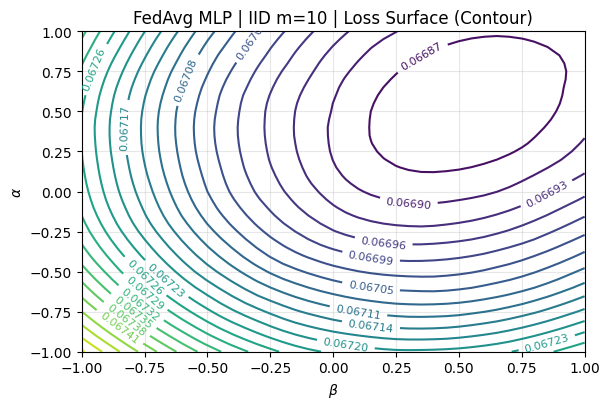

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use your final trained model (after fed_avg_experiment)
final_model = mlp_iid_m10  # this should contain the final global weights

alphas, betas, Z = loss_surface_2d(
    model=final_model,
    loader=test_loader,
    device=device,
    span=1.0,         # try 0.5, 1.0, 2.0
    steps=41,         # 31/41 good; larger is slower
    max_batches=10    # increase for smoother surface (slower)
)

fig3d, fig2d = plot_surface_and_contour(alphas, betas, Z, title="FedAvg MLP | IID m=10 | Loss Surface")

fig3d.savefig("loss_surface_3d.pdf")
fig2d.savefig("loss_surface_contour.pdf")
plt.show()

In [54]:
# MLP - iid - m=50 experiment
mlp_iid_m50 = copy.deepcopy(mlp)
acc_mlp_iid_m50 = fed_avg_experiment(mlp_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m50')
print(acc_mlp_iid_m50)
np.save('./acc_mlp_iid_m50.npy', acc_mlp_iid_m50)

starting round 0
clients:  [19 25 50 55  3 72 46 71 26  1 81 47 76 98 48 80 78 73  0 20 96 63 93 77
 11 60 16 36 39 54 95 21 61 91 42 35 18 52 86 51 64 14 58 33 49 38 43  5
 44  6]
round 0, starting client 1/50, id: 19
round 0, starting client 2/50, id: 25
round 0, starting client 3/50, id: 50
round 0, starting client 4/50, id: 55
round 0, starting client 5/50, id: 3
round 0, starting client 6/50, id: 72
round 0, starting client 7/50, id: 46
round 0, starting client 8/50, id: 71
round 0, starting client 9/50, id: 26
round 0, starting client 10/50, id: 1
round 0, starting client 11/50, id: 81
round 0, starting client 12/50, id: 47
round 0, starting client 13/50, id: 76
round 0, starting client 14/50, id: 98
round 0, starting client 15/50, id: 48
round 0, starting client 16/50, id: 80
round 0, starting client 17/50, id: 78
round 0, starting client 18/50, id: 73
round 0, starting client 19/50, id: 0
round 0, starting client 20/50, id: 20
round 0, starting client 21/50, id: 96
round 0, sta

In [55]:
# MLP - non-iid - m=10 experiment
mlp_noniid_m10 = copy.deepcopy(mlp)
acc_mlp_noniid_m10 = fed_avg_experiment(mlp_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename = './acc_mlp_noniid_m10')
print(acc_mlp_noniid_m10)
np.save('./acc_mlp_noniid_m10.npy', acc_mlp_noniid_m10)

starting round 0
clients:  [99 74  6 83 73 34 19 35 71 25]
round 0, starting client 1/10, id: 99
round 0, starting client 2/10, id: 74
round 0, starting client 3/10, id: 6
round 0, starting client 4/10, id: 83
round 0, starting client 5/10, id: 73
round 0, starting client 6/10, id: 34
round 0, starting client 7/10, id: 19
round 0, starting client 8/10, id: 35
round 0, starting client 9/10, id: 71
round 0, starting client 10/10, id: 25
round 0, validation acc: 0.1984
starting round 1
clients:  [86 53 67 21 11  2 59 97 36 44]
round 1, starting client 1/10, id: 86
round 1, starting client 2/10, id: 53
round 1, starting client 3/10, id: 67
round 1, starting client 4/10, id: 21
round 1, starting client 5/10, id: 11
round 1, starting client 6/10, id: 2
round 1, starting client 7/10, id: 59
round 1, starting client 8/10, id: 97
round 1, starting client 9/10, id: 36
round 1, starting client 10/10, id: 44
round 1, validation acc: 0.3084
starting round 2
clients:  [12 94 83  3 89 91 60 71 11 29]

In [56]:
# MLP - noniid - m=50 experiment
mlp_noniid_m50 = copy.deepcopy(mlp)
acc_mlp_noniid_m50 = fed_avg_experiment(mlp_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_mlp_noniid_m50')
print(acc_mlp_noniid_m50)
np.save('./acc_mlp_noniid_m50.npy', acc_mlp_noniid_m50)

starting round 0
clients:  [49 46 42 72 15 93 22 30 61  3 80 74 73 28 68 21 48 44 78 20  8 19 10 39
 60 12 76 54 87 51 40 66 11 29 26 38 16 84 34 37  1 65  9 18 57 14 59 47
 86 27]
round 0, starting client 1/50, id: 49
round 0, starting client 2/50, id: 46
round 0, starting client 3/50, id: 42
round 0, starting client 4/50, id: 72
round 0, starting client 5/50, id: 15
round 0, starting client 6/50, id: 93
round 0, starting client 7/50, id: 22
round 0, starting client 8/50, id: 30
round 0, starting client 9/50, id: 61
round 0, starting client 10/50, id: 3
round 0, starting client 11/50, id: 80
round 0, starting client 12/50, id: 74
round 0, starting client 13/50, id: 73
round 0, starting client 14/50, id: 28
round 0, starting client 15/50, id: 68
round 0, starting client 16/50, id: 21
round 0, starting client 17/50, id: 48
round 0, starting client 18/50, id: 44
round 0, starting client 19/50, id: 78
round 0, starting client 20/50, id: 20
round 0, starting client 21/50, id: 8
round 0, st

## CNN Experiments

In [64]:
cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)
total params:  582026


In [65]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m10')
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

starting round 0
clients:  [20  6 30 38 40 11 89  5 53 82]
round 0, starting client 1/10, id: 20
round 0, starting client 2/10, id: 6
round 0, starting client 3/10, id: 30
round 0, starting client 4/10, id: 38
round 0, starting client 5/10, id: 40
round 0, starting client 6/10, id: 11
round 0, starting client 7/10, id: 89
round 0, starting client 8/10, id: 5
round 0, starting client 9/10, id: 53
round 0, starting client 10/10, id: 82
round 0, validation acc: 0.9118
starting round 1
clients:  [ 5 88 41 43 56 33 35 82 95 83]
round 1, starting client 1/10, id: 5
round 1, starting client 2/10, id: 88
round 1, starting client 3/10, id: 41
round 1, starting client 4/10, id: 43
round 1, starting client 5/10, id: 56
round 1, starting client 6/10, id: 33
round 1, starting client 7/10, id: 35
round 1, starting client 8/10, id: 82
round 1, starting client 9/10, id: 95
round 1, starting client 10/10, id: 83
round 1, validation acc: 0.9382
starting round 2
clients:  [96  6 82 18 32 73 34 77 45 54]


In [66]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)

starting round 0
clients:  [97 72 77 84 57  1 94 32 15 50 75 51 71  0 93 76 16 41 95 27 30 80 55 85
 67 18 38 70 68 25 40 89 39 23  7 13 14 56 22 48 60 61 36 11 83 99  5 37
 42 33]
round 0, starting client 1/50, id: 97
round 0, starting client 2/50, id: 72
round 0, starting client 3/50, id: 77
round 0, starting client 4/50, id: 84
round 0, starting client 5/50, id: 57
round 0, starting client 6/50, id: 1
round 0, starting client 7/50, id: 94
round 0, starting client 8/50, id: 32
round 0, starting client 9/50, id: 15
round 0, starting client 10/50, id: 50
round 0, starting client 11/50, id: 75
round 0, starting client 12/50, id: 51
round 0, starting client 13/50, id: 71
round 0, starting client 14/50, id: 0
round 0, starting client 15/50, id: 93
round 0, starting client 16/50, id: 76
round 0, starting client 17/50, id: 16
round 0, starting client 18/50, id: 41
round 0, starting client 19/50, id: 95
round 0, starting client 20/50, id: 27
round 0, starting client 21/50, id: 30
round 0, st

In [67]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

starting round 0
clients:  [48 37 76 23 53 21 96 46 93 73]
round 0, starting client 1/10, id: 48
round 0, starting client 2/10, id: 37
round 0, starting client 3/10, id: 76
round 0, starting client 4/10, id: 23
round 0, starting client 5/10, id: 53
round 0, starting client 6/10, id: 21
round 0, starting client 7/10, id: 96
round 0, starting client 8/10, id: 46
round 0, starting client 9/10, id: 93
round 0, starting client 10/10, id: 73
round 0, validation acc: 0.2024
starting round 1
clients:  [37 92 36 72 12 26 90 27 52 15]
round 1, starting client 1/10, id: 37
round 1, starting client 2/10, id: 92
round 1, starting client 3/10, id: 36
round 1, starting client 4/10, id: 72
round 1, starting client 5/10, id: 12
round 1, starting client 6/10, id: 26
round 1, starting client 7/10, id: 90
round 1, starting client 8/10, id: 27
round 1, starting client 9/10, id: 52
round 1, starting client 10/10, id: 15
round 1, validation acc: 0.2933
starting round 2
clients:  [15  4 37 95 63 61 65 80 39 4

In [68]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=50, 
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)

starting round 0
clients:  [47  8 94 84 33 48 59 96 32 10  1 13 24 12 42  3 41 39 79 49  2 45  4 58
 16 34 82 92 90 28 95 97 74 80 93 63 77 78  6 76 72 64 55 91 86 38 83 60
 30 68]
round 0, starting client 1/50, id: 47
round 0, starting client 2/50, id: 8
round 0, starting client 3/50, id: 94
round 0, starting client 4/50, id: 84
round 0, starting client 5/50, id: 33
round 0, starting client 6/50, id: 48
round 0, starting client 7/50, id: 59
round 0, starting client 8/50, id: 96
round 0, starting client 9/50, id: 32
round 0, starting client 10/50, id: 10
round 0, starting client 11/50, id: 1
round 0, starting client 12/50, id: 13
round 0, starting client 13/50, id: 24
round 0, starting client 14/50, id: 12
round 0, starting client 15/50, id: 42
round 0, starting client 16/50, id: 3
round 0, starting client 17/50, id: 41
round 0, starting client 18/50, id: 39
round 0, starting client 19/50, id: 79
round 0, starting client 20/50, id: 49
round 0, starting client 21/50, id: 2
round 0, star

In [69]:
# view_10(x_debug[:10].to(cpu), torch.argmax(model(x_debug),dim=1)[:10].to(cpu))

# m = CNN().to(cuda)
# m.train()
# lr = 0.01
# opt = torch.optim.SGD(m.parameters(), lr)

# for epoch in range(5):
#     for (t, (x,y)) in enumerate(train_loader):
#         x = x.to(cuda)
#         y = y.to(cuda)
#         opt.zero_grad()
#         out = m(x)
#         loss = criterion(out, y)
#         loss.backward()
#         opt.step()

#         if (t%100 == 0):
#             print("epoch {}, step {}, loss: {}".format(epoch, t, loss))

#     print("running validation")
#     acc = validate(m)
#     print("epoch {} validation acc: {}".format(epoch, acc))